In [1]:
import os

xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

import bernstein_coeff_order10_arbitinterval, bernstein_coeff_ordern_arbitinterval
from functools import partial
import numpy as np
import jax.numpy as jnp
import mujoco
import mujoco.mjx as mjx 
import jax
import time

from mjx_planner import cem_planner

In [2]:
num_dof = 6
num_batch = 500
num_steps = 50
maxiter_projection = 20
maxiter_cem = 1
w_pos = 1
w_rot = 0.5
w_col = 10
num_elite = 0.05
timestep = 0.05

start_time = time.time()
#opt_class = cem_planner(num_dof, num_batch, w_pos=3, num_elite=0.1, maxiter_cem=30)	
opt_class = cem_planner(num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, maxiter_cem=maxiter_cem,
                        w_pos=w_pos, w_rot=w_rot, w_col=w_col, num_elite=num_elite, timestep=timestep,
                        maxiter_projection=maxiter_projection)

start_time_comp_cem = time.time()
xi_mean = jnp.zeros(opt_class.nvar)
xi_cov = 10.0*jnp.identity(opt_class.nvar)
init_pos = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# init_pos = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0])
# init_pos = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
init_vel = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
init_acc = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
target_pos = jnp.array([0.0, 0.0, 0.0])
target_rot = jnp.array([0.0, 0.0, 0.0, 1.0])
s_init = jnp.zeros((opt_class.num_batch, opt_class.num_total_constraints))
lamda_init = jnp.zeros((opt_class.num_batch, opt_class.nvar))

cost, best_cost_g, best_cost_r, best_cost_c, best_vels, best_traj, xi_mean, xi_cov, thetadot, theta = opt_class.compute_cem(xi_mean,
                                                                                                xi_cov,
                                                                                                init_pos, init_vel, 
                                                                                                init_acc, target_pos, target_rot,
                                                                                                lamda_init, s_init)

print(f"best_vels: {best_vels.shape}")
print(f"Total time: {round(time.time()-start_time, 2)}s")
print(f"Compute CEM time: {round(time.time()-start_time_comp_cem, 2)}s")
    

/home/alinjar/manipulator_torch_env/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))



 Default backend: gpu
 Model path: /home/alinjar/manipulator/manipulator_mujoco/sampling_based_planner/ur5e_hande_mjx/scene.xml 
 Timestep: 0.05 
 CEM Iter: 1 
 Number of batches: 500 
 Number of steps per trajectory: 50 
 Time per trajectory: 2.5
state_term.shape: (Array(500, dtype=int32), Array(12, dtype=int32))
num_eq_constraint: 2
b_vel: (Array(500, dtype=int32), Array(600, dtype=int32))
b_acc: (Array(500, dtype=int32), Array(588, dtype=int32))
b_pos: (Array(500, dtype=int32), Array(600, dtype=int32))
b_vel: (Array(500, dtype=int32), Array(600, dtype=int32))
b_acc: (Array(500, dtype=int32), Array(588, dtype=int32))
b_pos: (Array(500, dtype=int32), Array(600, dtype=int32))
b_vel: (Array(500, dtype=int32), Array(600, dtype=int32))
b_acc: (Array(500, dtype=int32), Array(588, dtype=int32))
b_pos: (Array(500, dtype=int32), Array(600, dtype=int32))
b_vel: (Array(500, dtype=int32), Array(600, dtype=int32))
b_acc: (Array(500, dtype=int32), Array(588, dtype=int32))
b_pos: (Array(500, dtype

In [3]:
print(opt_class.Pint.shape)
print(opt_class.P.shape)

# print(opt_class.Pint)
# print(opt_class.P)
# print(opt_class.Pdot)

initi = np.vstack((opt_class.Pint[0], opt_class.P[0], opt_class.Pdot[0], opt_class.P[-1], opt_class.Pdot[-1]  ))

print(initi.shape)
print(initi)

(50, 50)
(50, 50)
(5, 50)
[[  0.05   0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [-20.    20.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   

(50, 6)


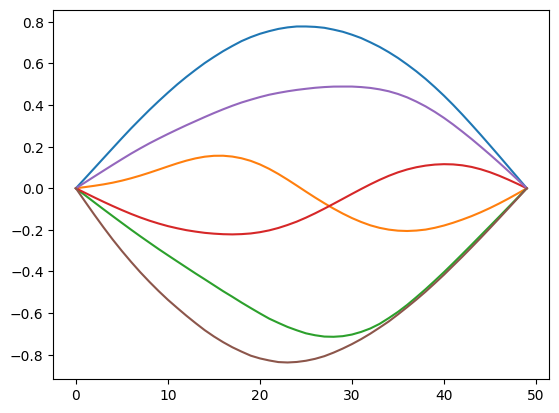

In [4]:
print(best_vels.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(best_vels)
plt.show()



(1, 500, 300)


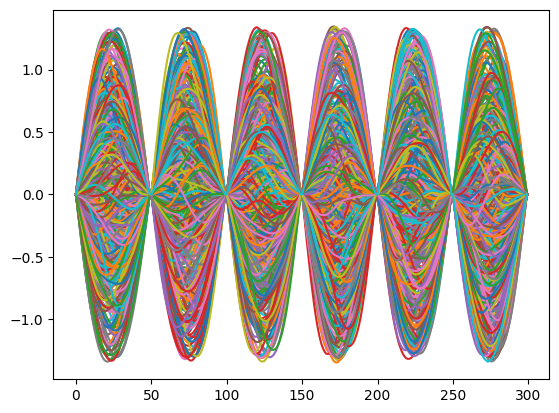

In [5]:
print(thetadot.shape)



%matplotlib inline
plt.figure()
plt.plot(thetadot[-1].T)
plt.show()


(500, 1)
(500, 1)


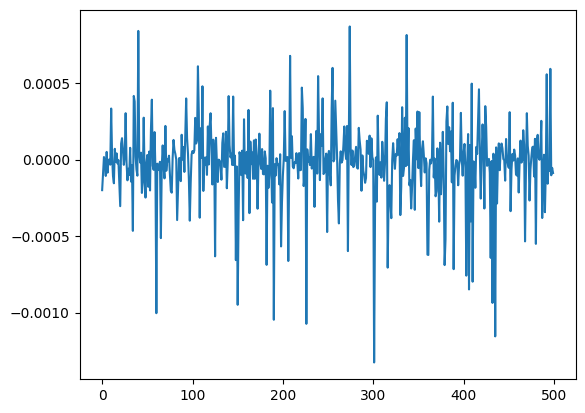

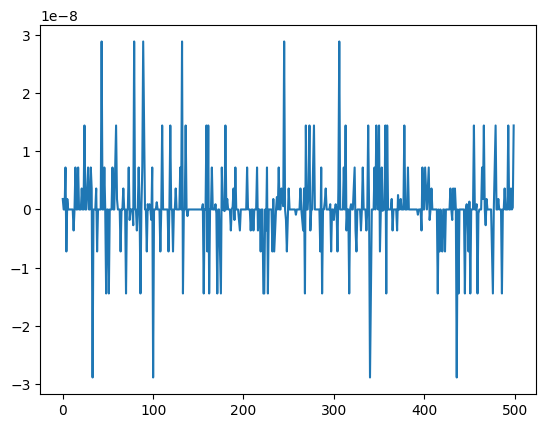

In [6]:
vel_start = np.zeros((num_batch, 1))
vel_end = np.zeros((num_batch, 1))

for i in range(num_batch):
    vel_start[i] = thetadot[-1][i][0]
    vel_end[i] = thetadot[-1][i][-1]

print(vel_start.shape)
print(vel_end.shape)

%matplotlib inline

plt.figure()
plt.plot(vel_start)
plt.show()

plt.figure()
plt.plot(vel_end)
plt.show()




(1, 500, 300)


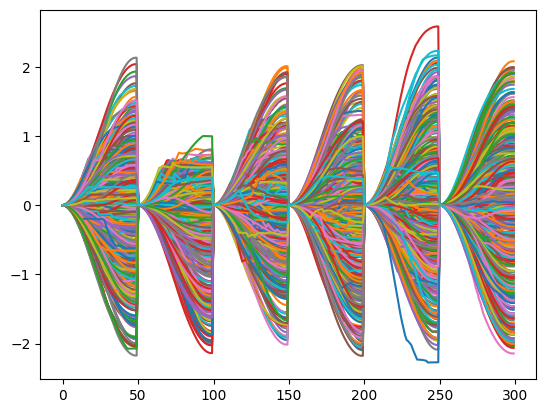

In [7]:
print(theta.shape)
%matplotlib inline
plt.figure()
plt.plot(theta[-1].T)
plt.show()

(500, 1)
(500, 1)


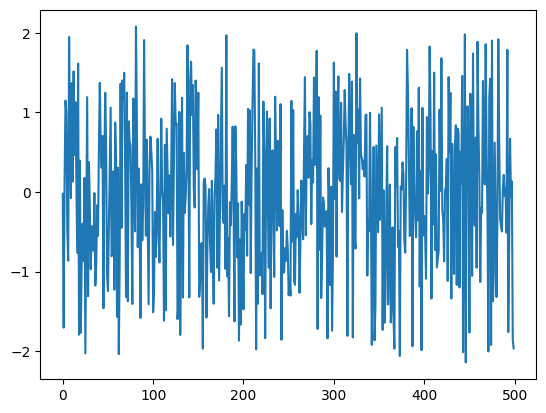

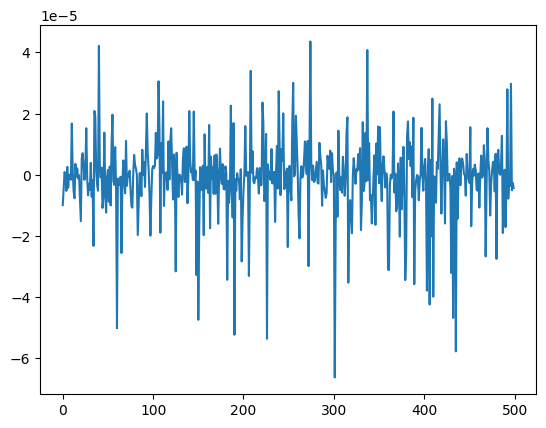

: 

In [ ]:
theta_start = np.zeros((num_batch, 1))
theta_end = np.zeros((num_batch, 1))

for i in range(num_batch):
    theta_start[i] = theta[-1][i][0]
    theta_end[i] = theta[-1][i][-1]

print(theta_start.shape)
print(theta_end.shape)

%matplotlib inline
plt.figure()
plt.plot(theta_end)
plt.show()

plt.figure()
plt.plot(theta_start)
plt.show()